In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

from astropy.timeseries import LombScargle

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 0.8,
})

cm = 1/2.54  # centimeters in inches

In [7]:
chandra_data=np.loadtxt('../data/chandra_2402obs_J1832_photon_info.txt')
epoch_info=np.loadtxt('../data/chandra_2402obs_J1832_epoch.txt')

# convert chandra second to mjd - https://cxc.cfa.harvard.edu/ciao/ahelp/times.html
toas = (chandra_data[:, 0] + 50814.0 * 86400.) / 86400. # in seconds mjd
engs = chandra_data[:, 1]

In [8]:
def check_bin_photon(binedges, toas):
    return ((toas > binedges[0]) & (toas < binedges[1])).sum()

# make time beams based on the epoch information
epoch_timebins = []
epoch_times = []
for epoch in epoch_info:
    es = epoch[0] / 86400. + 50814.
    ee = epoch[1] / 86400. + 50814.
    times = np.arange(es, ee+1/86400, 30/86400)
    epoch_timebins.append([(times[i], times[i+1]) for i in range(len(times) - 1)])
    epoch_times.append((times[1:] + times[:-1]) / 2)

epoch_bincounts = []
for ebins in epoch_timebins:
    counts = [check_bin_photon(edge, toas) for edge in ebins]
    epoch_bincounts.append(counts)

alltimes = np.hstack(epoch_times) * 86400 # in the unit of seconds...
allcounts = np.hstack(epoch_bincounts, )

In [9]:
# Lomb-Scargle periodogram search
frequency = np.linspace(8e-5, 1e-2, 20000)
ls = LombScargle(alltimes, allcounts, normalization = 'standard')
power = ls.power(frequency)

def get_sigificance_threshold(ls, frequency, false_alarm_level):
    return ls.false_alarm_level(
        false_alarm_level, minimum_frequency = frequency[0], 
        maximum_frequency = frequency[-1],method='baluev'
    )

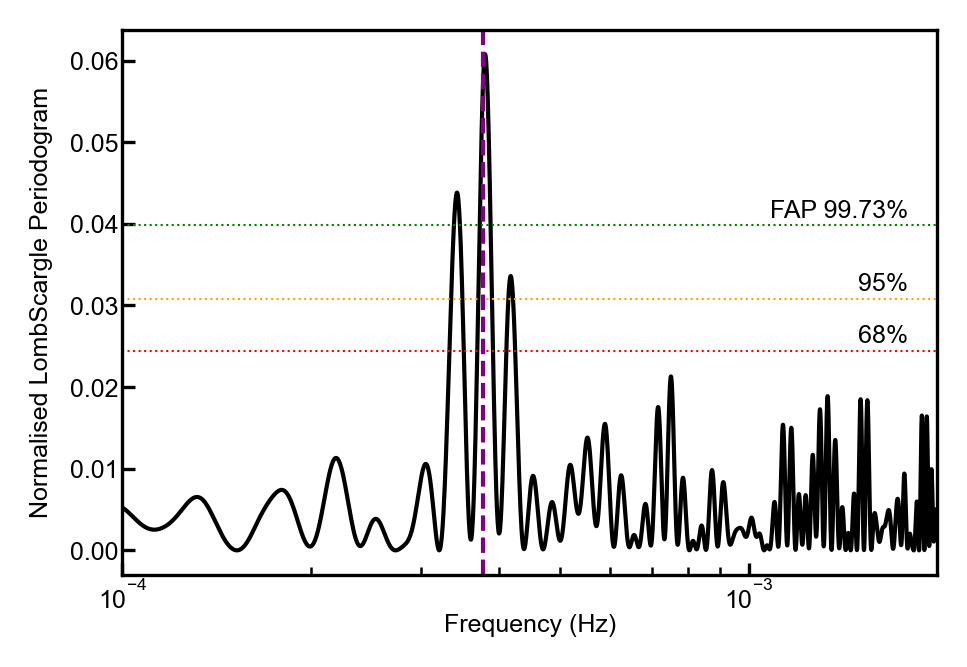

In [10]:
radio_freq = 1 / 2656.2412
fig = plt.figure(figsize=(8.9*cm, 6*cm))
ax = fig.add_subplot(1, 1, 1)


ax.plot(frequency, power, color='k', label="Lomb-Scargle Power", lw=1.0)
ax.axhline(y=get_sigificance_threshold(ls, frequency, 0.0027), color="green", ls=":", lw=0.5)
ax.axhline(y=get_sigificance_threshold(ls, frequency, 0.05), color="orange", ls=":", lw=0.5)
ax.axhline(y=get_sigificance_threshold(ls, frequency, 0.32), color="red", ls=":", lw=0.5)

FAlevels = [0.0027, 0.05, 0.32]
FAtexts = [r"FAP 99.73%", r"95%", r"68%"]
for FAlevel, FAtext in zip(FAlevels, FAtexts):
    yval = get_sigificance_threshold(ls, frequency, FAlevel)
    ax.text(x=1.8e-3, y=yval + 0.001, s=FAtext, ha="right")
    

ax.axvline(x=radio_freq, color="purple", ls="--", lw=1.0)

ax.set_xscale("log")
ax.set_xlim(1e-4, 2e-3)
ax.set_xlabel("Frequency (Hz)", labelpad=0.15)
ax.set_ylabel("Normalised LombScargle Periodogram")
ax.tick_params(axis="both", which="major", pad=1.0)

# fig.savefig("xray_lombscargle.pdf", bbox_inches="tight", dpi=300)
fig.savefig("xray_lombscargle.jpg", bbox_inches="tight", dpi=300)